# Training CNNs

To not "polute" the main file with the network training, the models are trained in this file and then saved to a folder (models)

In [2]:
import numpy as np
import pandas as pd

import os
#import random
#from operator import itemgetter
import copy
import time
from datetime import datetime

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
from torchvision.utils import make_grid
import torch.nn.functional as F

#from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
#import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image

import glob

from tqdm import tqdm

import seaborn as sns

import pickle

from torch.utils.tensorboard import SummaryWriter


#import warnings
#warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device being used : " + str(device))

Device being used : cuda:0


Define paths and categories (labels)

In [3]:
path_dataset = "flowers"
path_split = "tvt_flowers"
path_models = "models"
path_data_plots = "data_plots"
path_plots = "plots"
path_models = "models"

training_data_path = os.path.join(path_split,"train")
training_aug_data_path = os.path.join(path_split,"train_aug")
validation_data_path = os.path.join(path_split,"val")
testing_data_path =os.path.join(path_split,"test")
train_less_aug_path = os.path.join(path_split,"train_less_aug")
train_simple_aug_path = os.path.join(path_split,"train_simple_aug")
train_norm_path = os.path.join(path_split,"train_normalized")
train_one_aug_path = os.path.join(path_split,"train_one_aug")

categories=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
channel_means = torch.Tensor([0.4590, 0.4201, 0.3005])
channel_std = torch.Tensor([0.2940, 0.2635, 0.2863])

Import the training data produced by the "data_preparation.ipynb"

In [5]:
transformation = transforms.Compose([   transforms.Resize((220, 220)),
                                        transforms.ToTensor()])   

transformation_norm = transforms.Compose([  transforms.Resize((220, 220)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((channel_means[0].item(), channel_means[1].item(), channel_means[2].item()), 
                                                                    (channel_std[0].item(), channel_std[1].item(), channel_std[2].item()))
                                        ])                                                                                           

training_ds = ImageFolder(training_data_path, transform = transformation)
training_aug_ds =  ImageFolder(training_aug_data_path, transform = transformation)
val_ds = ImageFolder(validation_data_path, transform = transformation)
test_ds = ImageFolder(testing_data_path, transform = transformation)
training_less_aug_ds = ImageFolder(train_less_aug_path, transform = transformation)
training_simple_aug_ds = ImageFolder(train_simple_aug_path, transform = transformation)
training_norm_ds = ImageFolder(training_data_path, transform = transformation_norm)
val_norm_ds = ImageFolder(validation_data_path, transform = transformation_norm)
test_norm_ds = ImageFolder(testing_data_path, transform = transformation_norm)
training_one_aug_ds = ImageFolder(train_one_aug_path, transform=transformation)

The code was firstly built using the train_test_split function, therefore, the training function is built in such a way to receive this type of output. In order to not change the training code completely, the train_test_split function is still used, removing only one sample and then appending it again. This may take a bit just because it is copying the whole arrays to new variables.

Note : Takes a couple minutes

In [5]:
print("Transfering data to a different array")

#Val dataset
val_ds, discard = train_test_split(val_ds, test_size=1)
val_ds.append(discard[0])
print("Finished copying validation data")

#Val normalized dataset
val_norm_ds, discard = train_test_split(val_norm_ds, test_size=1)
val_norm_ds.append(discard[0])
print("Finished copying normalized validation data")

#Augmented dataset
training_aug_ds, discard = train_test_split(training_aug_ds, test_size=1)
training_aug_ds.append(discard[0])
print("Finished copying training data augmented")

#No aug dataset
training_ds, discard = train_test_split(training_ds, test_size=1)
training_ds.append(discard[0])
print("Finished copying training data not augmented")

#Less aug
training_less_aug_ds, discard = train_test_split(training_less_aug_ds, test_size=1)
training_less_aug_ds.append(discard[0])
print("Finished copying training data less augmented")

#Simple aug (Flip_Rot_aff, Random Erasing, Collor Jiter)
training_simple_aug_ds, discard = train_test_split(training_simple_aug_ds, test_size=1)
training_simple_aug_ds.append(discard[0])
print("Finished copying training data simple augmented")

#Normalized training data
training_norm_ds, discard = train_test_split(training_norm_ds, test_size=1)
training_norm_ds.append(discard[0])
print("Finished copying normalized training data ")

#One Aug training data (Flip_Rot_aff)
training_one_aug_ds, discard = train_test_split(training_one_aug_ds, test_size=1)
training_one_aug_ds.append(discard[0])
print("Finished copying one aug training data ")

Transfering data to a different array
Finished copying validation data
Finished copying normalized validation data
Finished copying training data augmented
Finished copying training data not augmented
Finished copying training data less augmented
Finished copying training data simple augmented
Finished copying normalized training data 
Finished copying one aug training data 


Define batch size, number of workwers, loaders and other used variables

In [15]:
bs = 32
nw = 4

loaders_no_aug = {
    'train': DataLoader(training_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

loaders_less_aug = {
    'train': DataLoader(training_less_aug_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test' : DataLoader(test_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

loaders_simple_aug = {
    'train': DataLoader(training_simple_aug_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

loaders_norm = {
    'train': DataLoader(training_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

loaders_norm_aug = {
    'train': DataLoader(training_aug_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

loaders_one_aug = {
    'train': DataLoader(training_one_aug_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'val': DataLoader(val_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
    'test': DataLoader(test_norm_ds, batch_size=bs, num_workers=nw, pin_memory=True),
}

dataset_sizes = {
    'train': len(training_aug_ds),
    'val': len(val_ds), 
    'test': len(test_ds),
}

dataset_sizes_no_aug = {
    'train': len(training_ds),
    'val': len(val_ds),
    'test': len(test_ds), 
}

dataset_sizes_less_aug = {
    'train': len(training_less_aug_ds),
    'val': len(val_ds),
    'test': len(test_ds), 
}

dataset_sizes_simple_aug = {
    'train': len(training_simple_aug_ds),
    'val': len(val_norm_ds),
    'test': len(test_norm_ds), 
}

dataset_sizes_norm_aug = {
    'train': len(training_simple_aug_ds),
    'val': len(val_norm_ds),
    'test': len(test_norm_ds), 
}

dataset_sizes_one_aug = {
    'train': len(training_one_aug_ds),
    'val': len(val_norm_ds),
    'test': len(test_norm_ds), 
}

Defining datastructures used to store the losses and accuraccies

In [8]:
losses_train = {
    'resnet18_no_tf' : [],
    'resnet18': [],
    'resnet18_no_aug' : [],
    'resnet18_less_aug' : [],
    'densenet121': [],
    'googlenet': [],
    'resnet101': [],
    'resnet101_no_aug' : [],
    'resnet101_less_aug' : [],
    'resnet18_simple_aug' : [],
    'resnet101_no_aug' : [],
    'resnet18_norm' : [],
    'resnet18_norm_aug' : [],
    'resenet101_norm_aug' : [],
    'resnet18_one_aug' : [],
    'resnet101_one_aug' : [],
}

losses_val = {
    'resnet18_no_tf' : [],
    'resnet18': [],
    'resnet18_no_aug' : [],
    'resnet18_less_aug' : [],
    'densenet121': [],
    'googlenet': [],
    'resnet101': [],
    'resnet101_no_aug' : [],
    'resnet101_less_aug' : [],
    'resnet18_simple_aug' : [],
    'resnet101_no_aug' : [],
    'resnet18_norm' : [],
    'resnet18_norm_aug' : [],
    'resenet101_norm_aug' : [],
    'resnet18_one_aug' : [],
    'resnet101_one_aug' : [],
}

accs_train = {
    'resnet18_no_tf' : [],
    'resnet18': [],
    'resnet18_no_aug' : [],
    'resnet18_less_aug' : [],
    'densenet121': [],
    'googlenet': [],
    'resnet101': [],
    'resnet101_no_aug' : [],
    'resnet101_less_aug' : [],
    'resnet18_simple_aug' : [],
    'resnet101_no_aug' : [],
    'resnet18_norm' : [],
    'resnet18_norm_aug' : [],
    'resenet101_norm_aug' : [],
    'resnet18_one_aug' : [],
    'resnet101_one_aug' : [],
}

accs_val = {
    'resnet18_no_tf' : [],
    'resnet18': [],
    'resnet18_no_aug' : [],
    'resnet18_less_aug' : [],
    'densenet121': [],
    'googlenet': [],
    'resnet101': [],
    'resnet101_no_aug' : [],
    'resnet101_less_aug' : [],
    'resnet18_simple_aug' : [],
    'resnet101_no_aug' : [],
    'resnet18_norm' : [],
    'resnet18_norm_aug' : [],
    'resenet101_norm_aug' : [],
    'resnet18_one_aug' : [],
    'resnet101_one_aug' : [],
}

Main functions to train, test, and plot the losses/accs of each network

In [9]:
#Inspired in https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#Trains de model, stores the losses/accuracies
def train_model(model, criterion, optimizer, scheduler, loaders, dataset_sizes, num_epochs=10):
    since = time.time()
    writer = SummaryWriter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    print("Starting Training of the network " + model.__class__.__name__ + "\n --------------------------------")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(loaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} \t Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
                writer.add_scalars('Train', {
                    'Loss': epoch_loss,
                    'Acc': epoch_acc
                }, epoch)
                writer.flush()

            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())
                writer.add_scalars('Validation', {
                    'Loss': epoch_loss,
                    'Accuracy': epoch_acc
                }, epoch)
                writer.flush()


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss, train_acc, val_loss, val_acc

#Inspired in https://discuss.pytorch.org/t/how-to-find-test-accuracy-after-training/88962/2
#Chcks the accuracy of a model in a test set
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return num_correct/num_samples * 100   

#Plots the loss graph and the accuracy graph for a given model
def plot_loss_acc(loss_train, loss_val, acc_train, acc_val, path_to_save, name, epochs=15):
    
    x_axis = np.arange(1,epochs+1)

    plt.figure(figsize=([6.4, 4.8]))

    plt.subplot(1,2,1)
    plt.plot(x_axis,loss_train, 'r', label='train')
    plt.plot(x_axis,loss_val, 'g', label='val')
    plt.title('Loss per sample')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    plt.plot(x_axis,acc_train, 'r', label='train')
    plt.plot(x_axis,acc_val, 'g', label='val')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")

    plt.tight_layout()

    plt.savefig(path_to_save + '\\' + name + '.png')

### Network Training

#### Resnet 18 - Normalize Data With Transfer Learning



Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.52it/s]


train 	 Loss: 0.7014 Acc: 0.7421


100%|██████████| 11/11 [00:02<00:00,  4.01it/s]


val 	 Loss: 0.4887 Acc: 0.8105

Epoch 1/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


train 	 Loss: 0.4311 Acc: 0.8374


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val 	 Loss: 0.6418 Acc: 0.7755

Epoch 2/14
----------


100%|██████████| 98/98 [00:16<00:00,  6.03it/s]


train 	 Loss: 0.3541 Acc: 0.8741


100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


val 	 Loss: 0.5842 Acc: 0.8047

Epoch 3/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


train 	 Loss: 0.3034 Acc: 0.8992


100%|██████████| 11/11 [00:02<00:00,  5.10it/s]


val 	 Loss: 0.6588 Acc: 0.7901

Epoch 4/14
----------


100%|██████████| 98/98 [00:16<00:00,  6.02it/s]


train 	 Loss: 0.1837 Acc: 0.9334


100%|██████████| 11/11 [00:02<00:00,  4.89it/s]


val 	 Loss: 2.5863 Acc: 0.5539

Epoch 5/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.76it/s]


train 	 Loss: 0.1661 Acc: 0.9424


100%|██████████| 11/11 [00:02<00:00,  4.52it/s]


val 	 Loss: 0.8381 Acc: 0.7784

Epoch 6/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.73it/s]


train 	 Loss: 0.1338 Acc: 0.9543


100%|██████████| 11/11 [00:02<00:00,  4.66it/s]


val 	 Loss: 1.1230 Acc: 0.7405

Epoch 7/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


train 	 Loss: 0.0606 Acc: 0.9807


100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


val 	 Loss: 0.4185 Acc: 0.8805

Epoch 8/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.80it/s]


train 	 Loss: 0.0171 Acc: 0.9961


100%|██████████| 11/11 [00:02<00:00,  4.67it/s]


val 	 Loss: 0.4174 Acc: 0.8717

Epoch 9/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


train 	 Loss: 0.0099 Acc: 0.9990


100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


val 	 Loss: 0.4320 Acc: 0.8776

Epoch 10/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.73it/s]


train 	 Loss: 0.0067 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  4.67it/s]


val 	 Loss: 0.4451 Acc: 0.8776

Epoch 11/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.72it/s]


train 	 Loss: 0.0048 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  4.41it/s]


val 	 Loss: 0.4558 Acc: 0.8776

Epoch 12/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.68it/s]


train 	 Loss: 0.0037 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  4.47it/s]


val 	 Loss: 0.4644 Acc: 0.8776

Epoch 13/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


train 	 Loss: 0.0030 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  4.32it/s]


val 	 Loss: 0.4717 Acc: 0.8776

Epoch 14/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


train 	 Loss: 0.0025 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  4.29it/s]


val 	 Loss: 0.4726 Acc: 0.8776

Training complete in 4m 50s
Best val Acc: 0.880466
---------------


100%|██████████| 28/28 [00:06<00:00,  4.31it/s]

Model Performance in Test Set : 90.67%


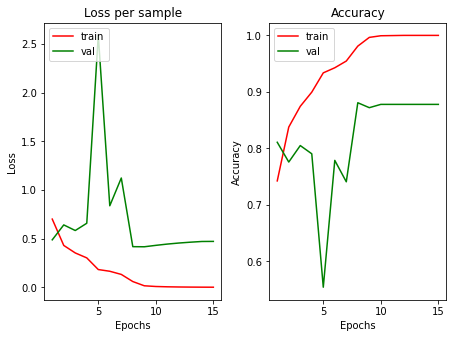

In [17]:
resnet18_norm = torchvision.models.resnet18(pretrained=True)

for param in resnet18_norm.parameters():
    param.grad_requires = False

num_ftrs = resnet18_norm.fc.in_features

resnet18_norm.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18 = resnet18_norm.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet18_norm.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_norm,losses_train['resnet18_norm'],accs_train['resnet18_norm'],losses_val['resnet18_norm'],accs_val['resnet18_norm'] = train_model(resnet18_norm, criterion, optimizer, exp_lr_scheduler,loaders_norm, dataset_sizes_no_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_norm.__class__.__name__ + '_18_norm')
torch.save(resnet18_norm.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_norm'],losses_val['resnet18_norm'],accs_train['resnet18_norm'],accs_val['resnet18_norm'], path_plots, 'resnet18_norm_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet18_norm)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet 18 - Normalized and Augmented Data (CIFAR, IMAGENET, SVHN) with Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 389/389 [00:59<00:00,  6.54it/s]


train 	 Loss: 0.7638 Acc: 0.7133


100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


val 	 Loss: 1.0353 Acc: 0.7143

Epoch 1/14
----------


100%|██████████| 389/389 [00:54<00:00,  7.16it/s]


train 	 Loss: 0.4802 Acc: 0.8203


100%|██████████| 11/11 [00:02<00:00,  4.61it/s]


val 	 Loss: 1.1501 Acc: 0.7289

Epoch 2/14
----------


100%|██████████| 389/389 [00:53<00:00,  7.24it/s]


train 	 Loss: 0.3570 Acc: 0.8686


100%|██████████| 11/11 [00:02<00:00,  4.51it/s]


val 	 Loss: 0.9875 Acc: 0.7726

Epoch 3/14
----------


100%|██████████| 389/389 [00:54<00:00,  7.15it/s]


train 	 Loss: 0.2629 Acc: 0.9052


100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


val 	 Loss: 1.6222 Acc: 0.7026

Epoch 4/14
----------


100%|██████████| 389/389 [00:55<00:00,  7.02it/s]


train 	 Loss: 0.2093 Acc: 0.9226


100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


val 	 Loss: 1.0113 Acc: 0.7930

Epoch 5/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.83it/s]


train 	 Loss: 0.1654 Acc: 0.9386


100%|██████████| 11/11 [00:02<00:00,  3.98it/s]


val 	 Loss: 1.0849 Acc: 0.7726

Epoch 6/14
----------


100%|██████████| 389/389 [00:55<00:00,  7.01it/s]


train 	 Loss: 0.1351 Acc: 0.9505


100%|██████████| 11/11 [00:02<00:00,  4.10it/s]


val 	 Loss: 0.8621 Acc: 0.8426

Epoch 7/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.92it/s]


train 	 Loss: 0.0639 Acc: 0.9760


100%|██████████| 11/11 [00:02<00:00,  3.98it/s]


val 	 Loss: 0.8468 Acc: 0.8309

Epoch 8/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.91it/s]


train 	 Loss: 0.0325 Acc: 0.9878


100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


val 	 Loss: 0.9201 Acc: 0.8251

Epoch 9/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.91it/s]


train 	 Loss: 0.0273 Acc: 0.9889


100%|██████████| 11/11 [00:02<00:00,  4.10it/s]


val 	 Loss: 0.9609 Acc: 0.8251

Epoch 10/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.84it/s]


train 	 Loss: 0.0242 Acc: 0.9900


100%|██████████| 11/11 [00:02<00:00,  4.07it/s]


val 	 Loss: 0.9932 Acc: 0.8280

Epoch 11/14
----------


100%|██████████| 389/389 [00:56<00:00,  6.86it/s]


train 	 Loss: 0.0222 Acc: 0.9910


100%|██████████| 11/11 [00:02<00:00,  4.08it/s]


val 	 Loss: 1.0111 Acc: 0.8280

Epoch 12/14
----------


100%|██████████| 389/389 [00:57<00:00,  6.79it/s]


train 	 Loss: 0.0205 Acc: 0.9915


100%|██████████| 11/11 [00:02<00:00,  3.91it/s]


val 	 Loss: 1.0308 Acc: 0.8251

Epoch 13/14
----------


100%|██████████| 389/389 [00:57<00:00,  6.82it/s]


train 	 Loss: 0.0191 Acc: 0.9919


100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


val 	 Loss: 1.0452 Acc: 0.8222

Epoch 14/14
----------


100%|██████████| 389/389 [00:57<00:00,  6.77it/s]


train 	 Loss: 0.0181 Acc: 0.9921


100%|██████████| 11/11 [00:02<00:00,  4.05it/s]


val 	 Loss: 1.0343 Acc: 0.8280

Training complete in 14m 45s
Best val Acc: 0.842566
---------------


100%|██████████| 28/28 [00:06<00:00,  4.31it/s]

Model Performance in Test Set : 84.33%


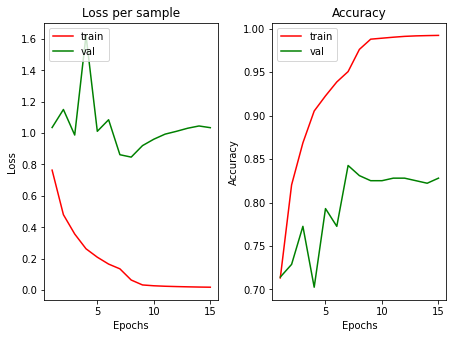

In [21]:
resnet18_norm_aug = torchvision.models.resnet18(pretrained=True)

for param in resnet18_norm_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet18_norm_aug.fc.in_features

resnet18_norm_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18 = resnet18_norm_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet18_norm_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_norm_aug,losses_train['resnet18_norm_aug'],accs_train['resnet18_norm_aug'],losses_val['resnet18_norm_aug'],accs_val['resnet18_norm_aug'] = train_model(resnet18_norm_aug, criterion, optimizer, exp_lr_scheduler,loaders_norm_aug, dataset_sizes_norm_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_norm_aug.__class__.__name__ + '_18_norm_aug')
torch.save(resnet18_norm_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_norm_aug'],losses_val['resnet18_norm_aug'],accs_train['resnet18_norm_aug'],accs_val['resnet18_norm_aug'], path_plots, 'resnet18_norm_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet18_norm_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet18 - Simple Augmentation and normalized Data with Trasnfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 389/389 [00:51<00:00,  7.56it/s]


train 	 Loss: 0.7558 Acc: 0.7147


100%|██████████| 11/11 [00:02<00:00,  4.52it/s]


val 	 Loss: 0.8818 Acc: 0.6997

Epoch 1/14
----------


100%|██████████| 389/389 [00:44<00:00,  8.70it/s]


train 	 Loss: 0.4964 Acc: 0.8139


100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


val 	 Loss: 0.9421 Acc: 0.7172

Epoch 2/14
----------


100%|██████████| 389/389 [00:45<00:00,  8.56it/s]


train 	 Loss: 0.3632 Acc: 0.8687


100%|██████████| 11/11 [00:04<00:00,  2.42it/s]


val 	 Loss: 0.5237 Acc: 0.8309

Epoch 3/14
----------


100%|██████████| 389/389 [00:58<00:00,  6.63it/s]


train 	 Loss: 0.2543 Acc: 0.9061


100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


val 	 Loss: 0.7414 Acc: 0.8076

Epoch 4/14
----------


100%|██████████| 389/389 [00:45<00:00,  8.54it/s]


train 	 Loss: 0.2111 Acc: 0.9233


100%|██████████| 11/11 [00:02<00:00,  5.49it/s]


val 	 Loss: 0.8146 Acc: 0.7726

Epoch 5/14
----------


100%|██████████| 389/389 [00:45<00:00,  8.52it/s]


train 	 Loss: 0.1608 Acc: 0.9392


100%|██████████| 11/11 [00:02<00:00,  5.40it/s]


val 	 Loss: 0.8621 Acc: 0.8251

Epoch 6/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.42it/s]


train 	 Loss: 0.1343 Acc: 0.9515


100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


val 	 Loss: 0.9061 Acc: 0.8076

Epoch 7/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.38it/s]


train 	 Loss: 0.0659 Acc: 0.9762


100%|██████████| 11/11 [00:02<00:00,  5.25it/s]


val 	 Loss: 0.7157 Acc: 0.8571

Epoch 8/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.35it/s]


train 	 Loss: 0.0336 Acc: 0.9868


100%|██████████| 11/11 [00:02<00:00,  5.22it/s]


val 	 Loss: 0.7143 Acc: 0.8513

Epoch 9/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.33it/s]


train 	 Loss: 0.0284 Acc: 0.9884


100%|██████████| 11/11 [00:02<00:00,  4.43it/s]


val 	 Loss: 0.7287 Acc: 0.8484

Epoch 10/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.28it/s]


train 	 Loss: 0.0256 Acc: 0.9886


100%|██████████| 11/11 [00:02<00:00,  4.61it/s]


val 	 Loss: 0.7429 Acc: 0.8455

Epoch 11/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.19it/s]


train 	 Loss: 0.0236 Acc: 0.9898


100%|██████████| 11/11 [00:02<00:00,  4.99it/s]


val 	 Loss: 0.7541 Acc: 0.8484

Epoch 12/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.17it/s]


train 	 Loss: 0.0218 Acc: 0.9903


100%|██████████| 11/11 [00:02<00:00,  5.03it/s]


val 	 Loss: 0.7644 Acc: 0.8484

Epoch 13/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.33it/s]


train 	 Loss: 0.0205 Acc: 0.9911


100%|██████████| 11/11 [00:02<00:00,  4.23it/s]


val 	 Loss: 0.7662 Acc: 0.8513

Epoch 14/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.22it/s]


train 	 Loss: 0.0188 Acc: 0.9921


100%|██████████| 11/11 [00:02<00:00,  4.69it/s]


val 	 Loss: 0.7689 Acc: 0.8484

Training complete in 12m 44s
Best val Acc: 0.857143
---------------


100%|██████████| 28/28 [00:06<00:00,  4.55it/s]

Model Performance in Test Set : 85.25%


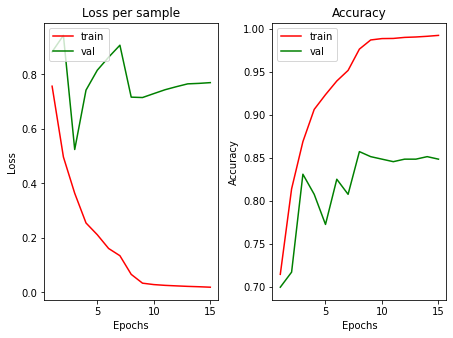

In [9]:
resnet18_norm_aug = torchvision.models.resnet18(pretrained=True)

for param in resnet18_norm_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet18_norm_aug.fc.in_features

resnet18_norm_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18_norm_aug = resnet18_norm_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet18_norm_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_norm_aug,losses_train['resnet18_norm_aug'],accs_train['resnet18_norm_aug'],losses_val['resnet18_norm_aug'],accs_val['resnet18_norm_aug'] = train_model(resnet18_norm_aug, criterion, optimizer, exp_lr_scheduler,loaders_norm_aug, dataset_sizes_norm_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_norm_aug.__class__.__name__ + '_18_norm_aug')
torch.save(resnet18_norm_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_norm_aug'],losses_val['resnet18_norm_aug'],accs_train['resnet18_norm_aug'],accs_val['resnet18_norm_aug'], path_plots, 'resnet18_norm_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet18_norm_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet18 - Normalized and One Augmentation Data with Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


train 	 Loss: 0.6121 Acc: 0.7830


100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


val 	 Loss: 0.7387 Acc: 0.7609

Epoch 1/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.52it/s]


train 	 Loss: 0.3835 Acc: 0.8606


100%|██████████| 11/11 [00:02<00:00,  5.27it/s]


val 	 Loss: 0.5715 Acc: 0.7872

Epoch 2/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.71it/s]


train 	 Loss: 0.3010 Acc: 0.8923


100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


val 	 Loss: 0.8749 Acc: 0.7522

Epoch 3/14
----------


100%|██████████| 195/195 [00:30<00:00,  6.37it/s]


train 	 Loss: 0.2089 Acc: 0.9282


100%|██████████| 11/11 [00:02<00:00,  4.13it/s]


val 	 Loss: 0.5964 Acc: 0.8222

Epoch 4/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.66it/s]


train 	 Loss: 0.1524 Acc: 0.9453


100%|██████████| 11/11 [00:02<00:00,  4.60it/s]


val 	 Loss: 0.4934 Acc: 0.8513

Epoch 5/14
----------


100%|██████████| 195/195 [00:30<00:00,  6.32it/s]


train 	 Loss: 0.1294 Acc: 0.9530


100%|██████████| 11/11 [00:02<00:00,  4.38it/s]


val 	 Loss: 1.0091 Acc: 0.7813

Epoch 6/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.64it/s]


train 	 Loss: 0.1445 Acc: 0.9496


100%|██████████| 11/11 [00:02<00:00,  4.47it/s]


val 	 Loss: 0.7316 Acc: 0.8309

Epoch 7/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.58it/s]


train 	 Loss: 0.0494 Acc: 0.9826


100%|██████████| 11/11 [00:02<00:00,  4.18it/s]


val 	 Loss: 0.4548 Acc: 0.8776

Epoch 8/14
----------


100%|██████████| 195/195 [00:31<00:00,  6.15it/s]


train 	 Loss: 0.0146 Acc: 0.9969


100%|██████████| 11/11 [00:02<00:00,  4.42it/s]


val 	 Loss: 0.4775 Acc: 0.8776

Epoch 9/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.63it/s]


train 	 Loss: 0.0085 Acc: 0.9984


100%|██████████| 11/11 [00:02<00:00,  4.45it/s]


val 	 Loss: 0.4976 Acc: 0.8746

Epoch 10/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.60it/s]


train 	 Loss: 0.0056 Acc: 0.9990


100%|██████████| 11/11 [00:02<00:00,  4.49it/s]


val 	 Loss: 0.5162 Acc: 0.8746

Epoch 11/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.62it/s]


train 	 Loss: 0.0040 Acc: 0.9992


100%|██████████| 11/11 [00:02<00:00,  4.57it/s]


val 	 Loss: 0.5323 Acc: 0.8746

Epoch 12/14
----------


100%|██████████| 195/195 [00:28<00:00,  6.76it/s]


train 	 Loss: 0.0031 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  4.45it/s]


val 	 Loss: 0.5459 Acc: 0.8776

Epoch 13/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.68it/s]


train 	 Loss: 0.0024 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  4.58it/s]


val 	 Loss: 0.5571 Acc: 0.8776

Epoch 14/14
----------


100%|██████████| 195/195 [00:29<00:00,  6.66it/s]


train 	 Loss: 0.0017 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  4.46it/s]


val 	 Loss: 0.5605 Acc: 0.8776

Training complete in 8m 6s
Best val Acc: 0.877551
---------------


100%|██████████| 28/28 [00:06<00:00,  4.34it/s]

Model Performance in Test Set : 89.29%


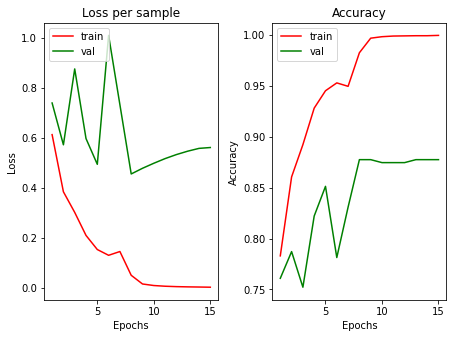

In [11]:
resnet18_one_aug = torchvision.models.resnet18(pretrained=True)

for param in resnet18_one_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet18_one_aug.fc.in_features

resnet18_one_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18_one_aug = resnet18_one_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet18_one_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_one_aug,losses_train['resnet18_one_aug'],accs_train['resnet18_one_aug'],losses_val['resnet18_one_aug'],accs_val['resnet18_one_aug'] = train_model(resnet18_one_aug, criterion, optimizer, exp_lr_scheduler,loaders_one_aug, dataset_sizes_one_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_one_aug.__class__.__name__ + '_18_one_aug')
torch.save(resnet18_one_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_one_aug'],losses_val['resnet18_one_aug'],accs_train['resnet18_one_aug'],accs_val['resnet18_one_aug'], path_plots, 'resnet18_one_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet18_one_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet101 - Normalized and One Augment Data with Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 195/195 [02:00<00:00,  1.61it/s]


train 	 Loss: 0.9510 Acc: 0.6578


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


val 	 Loss: 0.6984 Acc: 0.7259

Epoch 1/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.6235 Acc: 0.7750


100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


val 	 Loss: 1.0139 Acc: 0.6793

Epoch 2/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.4717 Acc: 0.8310


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


val 	 Loss: 0.6823 Acc: 0.7522

Epoch 3/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.57it/s]


train 	 Loss: 0.3565 Acc: 0.8674


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


val 	 Loss: 0.7846 Acc: 0.7347

Epoch 4/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.3226 Acc: 0.8851


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


val 	 Loss: 0.6286 Acc: 0.7901

Epoch 5/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.2747 Acc: 0.9050


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


val 	 Loss: 1.0026 Acc: 0.7347

Epoch 6/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.2186 Acc: 0.9224


100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


val 	 Loss: 0.6960 Acc: 0.8251

Epoch 7/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.1255 Acc: 0.9567


100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


val 	 Loss: 0.3592 Acc: 0.8746

Epoch 8/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.0490 Acc: 0.9878


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


val 	 Loss: 0.3685 Acc: 0.8892

Epoch 9/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.0252 Acc: 0.9961


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


val 	 Loss: 0.3908 Acc: 0.8776

Epoch 10/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.0129 Acc: 0.9987


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


val 	 Loss: 0.4313 Acc: 0.8746

Epoch 11/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.0066 Acc: 0.9990


100%|██████████| 11/11 [00:03<00:00,  3.21it/s]


val 	 Loss: 0.4881 Acc: 0.8630

Epoch 12/14
----------


100%|██████████| 195/195 [02:03<00:00,  1.58it/s]


train 	 Loss: 0.0038 Acc: 0.9992


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


val 	 Loss: 0.5335 Acc: 0.8630

Epoch 13/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.59it/s]


train 	 Loss: 0.0023 Acc: 0.9994


100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


val 	 Loss: 0.5753 Acc: 0.8630

Epoch 14/14
----------


100%|██████████| 195/195 [02:02<00:00,  1.60it/s]


train 	 Loss: 0.0014 Acc: 0.9998


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


val 	 Loss: 0.5787 Acc: 0.8659

Training complete in 31m 48s
Best val Acc: 0.889213
---------------


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]

Model Performance in Test Set : 87.67%


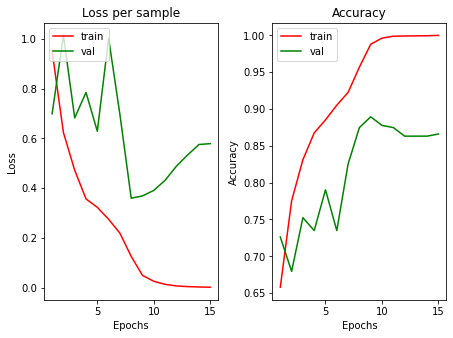

In [9]:
resnet101_one_aug = torchvision.models.resnet101(pretrained=True)

for param in resnet101_one_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet101_one_aug.fc.in_features

resnet101_one_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet101_one_aug = resnet101_one_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet101_one_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet101_one_aug,losses_train['resnet101_one_aug'],accs_train['resnet101_one_aug'],losses_val['resnet101_one_aug'],accs_val['resnet101_one_aug'] = train_model(resnet101_one_aug, criterion, optimizer, exp_lr_scheduler,loaders_one_aug, dataset_sizes_one_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet101_one_aug.__class__.__name__ + '_101_one_aug')
torch.save(resnet101_one_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet101_one_aug'],losses_val['resnet101_one_aug'],accs_train['resnet101_one_aug'],accs_val['resnet101_one_aug'], path_plots, 'resnet101_one_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet101_one_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet 101 - Normalized and Augmented (CIFAR,...) Data and Transfer Learning

In [ ]:
resnet101_norm_aug = torchvision.models.resnet101(pretrained=True)

for param in resnet101_norm_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet101_norm_aug.fc.in_features

resnet101_norm_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet101_norm_aug = resnet101_norm_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(resnet101_norm_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet101_norm_aug,losses_train['resnet101_norm_aug'],accs_train['resnet101_norm_aug'],losses_val['resnet101_norm_aug'],accs_val['resnet101_norm_aug'] = train_model(resnet101_norm_aug, criterion, optimizer, exp_lr_scheduler,loaders_norm_aug, dataset_sizes_norm_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet101_norm_aug.__class__.__name__ + 'resnet101_norm_aug')
torch.save(resnet101_norm_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet101_norm_aug'],losses_val['resnet101_norm_aug'],accs_train['resnet101_norm_aug'],accs_val['resnet101_norm_aug'], path_plots, 'resnet101_norm_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet101_norm_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#The Output is this block was erased but the loss/accuracy plot can be seen in the folder plots

#### Resnet 18 - Without Data Augmentation or Normalization and Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 98/98 [00:20<00:00,  4.70it/s]


train 	 Loss: 0.7479 Acc: 0.7354


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


val 	 Loss: 0.8651 Acc: 0.7201

Epoch 1/14
----------


100%|██████████| 98/98 [00:24<00:00,  3.98it/s]


train 	 Loss: 0.4571 Acc: 0.8358


100%|██████████| 11/11 [00:02<00:00,  4.01it/s]


val 	 Loss: 0.5289 Acc: 0.8017

Epoch 2/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.71it/s]


train 	 Loss: 0.3570 Acc: 0.8802


100%|██████████| 11/11 [00:02<00:00,  3.84it/s]


val 	 Loss: 1.4735 Acc: 0.6210

Epoch 3/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


train 	 Loss: 0.2684 Acc: 0.9066


100%|██████████| 11/11 [00:02<00:00,  3.90it/s]


val 	 Loss: 0.5925 Acc: 0.8134

Epoch 4/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


train 	 Loss: 0.1896 Acc: 0.9337


100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


val 	 Loss: 0.4293 Acc: 0.8542

Epoch 5/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.60it/s]


train 	 Loss: 0.1904 Acc: 0.9388


100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


val 	 Loss: 0.6951 Acc: 0.7988

Epoch 6/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.48it/s]


train 	 Loss: 0.2204 Acc: 0.9256


100%|██████████| 11/11 [00:02<00:00,  3.84it/s]


val 	 Loss: 0.5510 Acc: 0.8280

Epoch 7/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.64it/s]


train 	 Loss: 0.0855 Acc: 0.9742


100%|██████████| 11/11 [00:02<00:00,  3.85it/s]


val 	 Loss: 0.3370 Acc: 0.8776

Epoch 8/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.61it/s]


train 	 Loss: 0.0309 Acc: 0.9945


100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


val 	 Loss: 0.3426 Acc: 0.8805

Epoch 9/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.76it/s]


train 	 Loss: 0.0191 Acc: 0.9965


100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


val 	 Loss: 0.3531 Acc: 0.8834

Epoch 10/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.67it/s]


train 	 Loss: 0.0132 Acc: 0.9974


100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


val 	 Loss: 0.3654 Acc: 0.8863

Epoch 11/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.65it/s]


train 	 Loss: 0.0098 Acc: 0.9984


100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


val 	 Loss: 0.3779 Acc: 0.8892

Epoch 12/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.69it/s]


train 	 Loss: 0.0075 Acc: 0.9990


100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


val 	 Loss: 0.3899 Acc: 0.8892

Epoch 13/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.56it/s]


train 	 Loss: 0.0059 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


val 	 Loss: 0.4007 Acc: 0.8892

Epoch 14/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


train 	 Loss: 0.0045 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


val 	 Loss: 0.4004 Acc: 0.8921

Training complete in 5m 17s
Best val Acc: 0.892128
---------------


100%|██████████| 28/28 [00:06<00:00,  4.48it/s]

Model Performance in Test Set : 90.55%


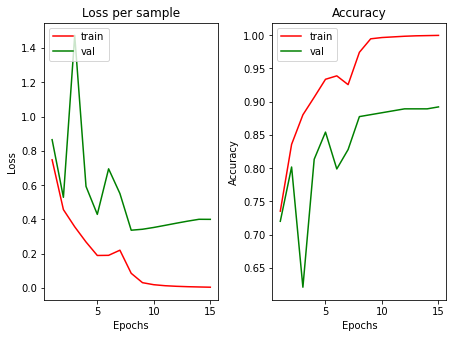

In [17]:
resnet18_no_aug = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet18_no_aug.fc.in_features

for param in resnet18_no_aug.parameters():
    param.grad_requires = False

resnet18_no_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18_no_aug = resnet18_no_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(resnet18_no_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet18_no_aug,losses_train['resnet18_no_aug'],accs_train['resnet18_no_aug'],losses_val['resnet18_no_aug'],accs_val['resnet18_no_aug'] = train_model(resnet18_no_aug, criterion, optimizer_ft, exp_lr_scheduler, loaders_no_aug, dataset_sizes_no_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_no_aug.__class__.__name__ + '_18_no_aug')
torch.save(resnet18_no_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_no_aug'],losses_val['resnet18_no_aug'],accs_train['resnet18_no_aug'],accs_val['resnet18_no_aug'], path_plots, 'resnet18_no_aug_plot')


print('-' * 15)

test_accuracy = check_accuracy(loaders_no_aug['test'], resnet18_no_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### Resnet 18 - Normalized Data and Without Transfer Learning

Note that now the parameters of the network cannot be frozen. This is because no transfer learning is being done, therefore, all the weights and biases of the network need to be updated each batch

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.45it/s]


train 	 Loss: 1.2922 Acc: 0.4697


100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


val 	 Loss: 1.1633 Acc: 0.5277

Epoch 1/14
----------


100%|██████████| 98/98 [00:16<00:00,  6.10it/s]


train 	 Loss: 1.0689 Acc: 0.5747


100%|██████████| 11/11 [00:02<00:00,  5.30it/s]


val 	 Loss: 0.9913 Acc: 0.6093

Epoch 2/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.95it/s]


train 	 Loss: 0.9875 Acc: 0.6188


100%|██████████| 11/11 [00:02<00:00,  5.01it/s]


val 	 Loss: 0.9615 Acc: 0.6414

Epoch 3/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


train 	 Loss: 0.9168 Acc: 0.6494


100%|██████████| 11/11 [00:01<00:00,  5.63it/s]


val 	 Loss: 1.0372 Acc: 0.6210

Epoch 4/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.64it/s]


train 	 Loss: 0.8822 Acc: 0.6639


100%|██████████| 11/11 [00:02<00:00,  4.87it/s]


val 	 Loss: 0.9714 Acc: 0.6531

Epoch 5/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.71it/s]


train 	 Loss: 0.8085 Acc: 0.6945


100%|██████████| 11/11 [00:02<00:00,  4.93it/s]


val 	 Loss: 1.0874 Acc: 0.6647

Epoch 6/14
----------


100%|██████████| 98/98 [00:15<00:00,  6.45it/s]


train 	 Loss: 0.7717 Acc: 0.7131


100%|██████████| 11/11 [00:02<00:00,  5.43it/s]


val 	 Loss: 0.9360 Acc: 0.6735

Epoch 7/14
----------


100%|██████████| 98/98 [00:15<00:00,  6.44it/s]


train 	 Loss: 0.6178 Acc: 0.7721


100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


val 	 Loss: 0.7212 Acc: 0.7347

Epoch 8/14
----------


100%|██████████| 98/98 [00:15<00:00,  6.15it/s]


train 	 Loss: 0.5585 Acc: 0.7943


100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


val 	 Loss: 0.7138 Acc: 0.7318

Epoch 9/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.60it/s]


train 	 Loss: 0.5211 Acc: 0.8097


100%|██████████| 11/11 [00:02<00:00,  4.44it/s]


val 	 Loss: 0.7152 Acc: 0.7347

Epoch 10/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.58it/s]


train 	 Loss: 0.4848 Acc: 0.8232


100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


val 	 Loss: 0.7237 Acc: 0.7434

Epoch 11/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.54it/s]


train 	 Loss: 0.4454 Acc: 0.8410


100%|██████████| 11/11 [00:02<00:00,  4.47it/s]


val 	 Loss: 0.7395 Acc: 0.7464

Epoch 12/14
----------


100%|██████████| 98/98 [00:15<00:00,  6.31it/s]


train 	 Loss: 0.4003 Acc: 0.8558


100%|██████████| 11/11 [00:02<00:00,  4.42it/s]


val 	 Loss: 0.7588 Acc: 0.7259

Epoch 13/14
----------


100%|██████████| 98/98 [00:15<00:00,  6.49it/s]


train 	 Loss: 0.3467 Acc: 0.8831


100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


val 	 Loss: 0.7785 Acc: 0.7201

Epoch 14/14
----------


100%|██████████| 98/98 [00:14<00:00,  6.60it/s]


train 	 Loss: 0.2706 Acc: 0.9140


100%|██████████| 11/11 [00:02<00:00,  4.56it/s]


val 	 Loss: 0.6861 Acc: 0.7638

Training complete in 4m 29s
Best val Acc: 0.763848
---------------


100%|██████████| 28/28 [00:05<00:00,  4.85it/s]

Model Performance in Test Set : 80.41%


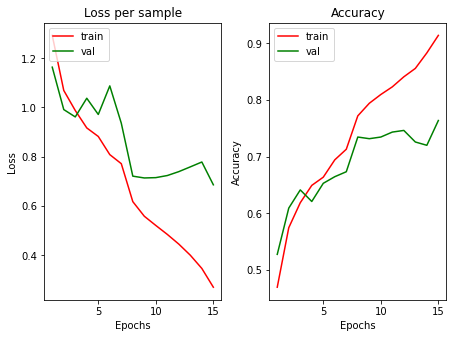

In [9]:
resnet18_no_tf = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet18_no_tf.fc.in_features

resnet18_no_tf.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18_no_aug_tf = resnet18_no_tf.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(resnet18_no_tf.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet18_no_tf,losses_train['resnet18_no_tf'],accs_train['resnet18_no_tf'],losses_val['resnet18_no_tf'],accs_val['resnet18_no_tf'] = train_model(resnet18_no_tf, criterion, optimizer_ft, exp_lr_scheduler,loaders_norm, dataset_sizes_no_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_no_tf.__class__.__name__ + '_18_no_tf')
torch.save(resnet18_no_tf.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_no_tf'],losses_val['resnet18_no_tf'],accs_train['resnet18_no_tf'],accs_val['resnet18_no_tf'], path_plots, 'resnet18_no_tf_plot')


print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], resnet18_no_tf)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### Resnet 18 - Simple Data Augmentation and With Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 389/389 [00:52<00:00,  7.48it/s]


train 	 Loss: 0.6291 Acc: 0.7690


100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


val 	 Loss: 1.7181 Acc: 0.6472

Epoch 1/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.21it/s]


train 	 Loss: 0.3805 Acc: 0.8608


100%|██████████| 11/11 [00:02<00:00,  4.49it/s]


val 	 Loss: 1.1843 Acc: 0.6793

Epoch 2/14
----------


100%|██████████| 389/389 [00:45<00:00,  8.54it/s]


train 	 Loss: 0.2792 Acc: 0.8967


100%|██████████| 11/11 [00:02<00:00,  5.34it/s]


val 	 Loss: 1.3777 Acc: 0.6501

Epoch 3/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.37it/s]


train 	 Loss: 0.1884 Acc: 0.9346


100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


val 	 Loss: 1.4558 Acc: 0.6793

Epoch 4/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.16it/s]


train 	 Loss: 0.1391 Acc: 0.9494


100%|██████████| 11/11 [00:02<00:00,  5.42it/s]


val 	 Loss: 2.1789 Acc: 0.6414

Epoch 5/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.34it/s]


train 	 Loss: 0.1261 Acc: 0.9569


100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


val 	 Loss: 1.5406 Acc: 0.6793

Epoch 6/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.32it/s]


train 	 Loss: 0.0885 Acc: 0.9692


100%|██████████| 11/11 [00:02<00:00,  5.32it/s]


val 	 Loss: 2.1567 Acc: 0.6676

Epoch 7/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.28it/s]


train 	 Loss: 0.0264 Acc: 0.9923


100%|██████████| 11/11 [00:02<00:00,  5.01it/s]


val 	 Loss: 1.6346 Acc: 0.7172

Epoch 8/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.32it/s]


train 	 Loss: 0.0055 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


val 	 Loss: 1.8019 Acc: 0.7143

Epoch 9/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.28it/s]


train 	 Loss: 0.0030 Acc: 0.9996


100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


val 	 Loss: 1.9181 Acc: 0.6997

Epoch 10/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.26it/s]


train 	 Loss: 0.0021 Acc: 0.9996


100%|██████████| 11/11 [00:02<00:00,  5.29it/s]


val 	 Loss: 2.0010 Acc: 0.6939

Epoch 11/14
----------


100%|██████████| 389/389 [00:46<00:00,  8.29it/s]


train 	 Loss: 0.0017 Acc: 0.9996


100%|██████████| 11/11 [00:02<00:00,  5.26it/s]


val 	 Loss: 2.0366 Acc: 0.6968

Epoch 12/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.26it/s]


train 	 Loss: 0.0015 Acc: 0.9998


100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


val 	 Loss: 2.1275 Acc: 0.6910

Epoch 13/14
----------


100%|██████████| 389/389 [00:47<00:00,  8.22it/s]


train 	 Loss: 0.0012 Acc: 0.9998


100%|██████████| 11/11 [00:02<00:00,  4.27it/s]


val 	 Loss: 2.1830 Acc: 0.6910

Epoch 14/14
----------


100%|██████████| 389/389 [00:50<00:00,  7.74it/s]


train 	 Loss: 0.0007 Acc: 0.9999


100%|██████████| 11/11 [00:02<00:00,  5.11it/s]


val 	 Loss: 2.1971 Acc: 0.6910

Training complete in 12m 25s
Best val Acc: 0.717201
---------------


100%|██████████| 28/28 [00:03<00:00,  7.41it/s]

Model Performance in Test Set : 71.77%


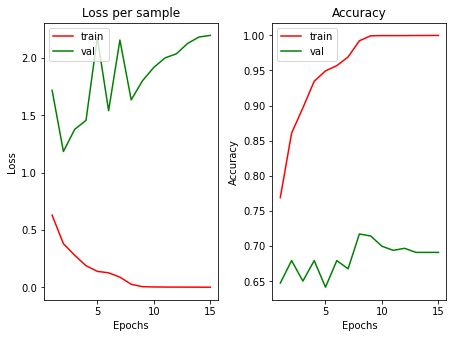

In [13]:
resnet18_simple_aug = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet18_simple_aug.fc.in_features

for param in resnet18_simple_aug.parameters():
    param.grad_requires = False

resnet18_simple_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet18_simple_aug = resnet18_simple_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(resnet18_simple_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet18_simple_aug,losses_train['resnet18_simple_aug'],accs_train['resnet18_simple_aug'],losses_val['resnet18_simple_aug'],accs_val['resnet18_simple_aug'] = train_model(resnet18_simple_aug, criterion, optimizer_ft, exp_lr_scheduler, loaders_simple_aug, dataset_sizes_simple_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet18_simple_aug.__class__.__name__ + '_18_simple_aug')
torch.save(resnet18_simple_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet18_simple_aug'],losses_val['resnet18_simple_aug'],accs_train['resnet18_simple_aug'],accs_val['resnet18_simple_aug'], path_plots, 'resnet18_simple_aug_plot')


print('-' * 15)

test_accuracy = check_accuracy(loaders_simple_aug['test'], resnet18_simple_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### GoogleNet

Starting Training of the network GoogLeNet
 --------------------------------
Epoch 0/14
----------


  0%|          | 0/98 [00:00<?, ?it/s]D:\miniconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


train 	 Loss: 0.5833 Acc: 0.7862


100%|██████████| 11/11 [00:02<00:00,  4.50it/s]


val 	 Loss: 0.6221 Acc: 0.7755

Epoch 1/14
----------


100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


train 	 Loss: 0.4268 Acc: 0.8535


100%|██████████| 11/11 [00:01<00:00,  6.26it/s]


val 	 Loss: 0.6236 Acc: 0.7813

Epoch 2/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.93it/s]


train 	 Loss: 0.3336 Acc: 0.8889


100%|██████████| 11/11 [00:01<00:00,  6.23it/s]


val 	 Loss: 0.4560 Acc: 0.8192

Epoch 3/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


train 	 Loss: 0.2064 Acc: 0.9282


100%|██████████| 11/11 [00:01<00:00,  5.68it/s]


val 	 Loss: 0.5289 Acc: 0.8134

Epoch 4/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.85it/s]


train 	 Loss: 0.1551 Acc: 0.9459


100%|██████████| 11/11 [00:01<00:00,  5.76it/s]


val 	 Loss: 0.6122 Acc: 0.8309

Epoch 5/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.80it/s]


train 	 Loss: 0.1354 Acc: 0.9562


100%|██████████| 11/11 [00:01<00:00,  5.76it/s]


val 	 Loss: 0.4502 Acc: 0.8571

Epoch 6/14
----------


100%|██████████| 98/98 [00:16<00:00,  5.81it/s]


train 	 Loss: 0.1489 Acc: 0.9520


100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


val 	 Loss: 0.7729 Acc: 0.8222

Epoch 7/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.70it/s]


train 	 Loss: 0.0833 Acc: 0.9736


100%|██████████| 11/11 [00:01<00:00,  5.52it/s]


val 	 Loss: 0.3355 Acc: 0.8892

Epoch 8/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.70it/s]


train 	 Loss: 0.0236 Acc: 0.9965


100%|██████████| 11/11 [00:01<00:00,  5.70it/s]


val 	 Loss: 0.3384 Acc: 0.8834

Epoch 9/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.63it/s]


train 	 Loss: 0.0140 Acc: 0.9984


100%|██████████| 11/11 [00:02<00:00,  5.04it/s]


val 	 Loss: 0.3464 Acc: 0.8863

Epoch 10/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.55it/s]


train 	 Loss: 0.0093 Acc: 0.9994


100%|██████████| 11/11 [00:02<00:00,  5.40it/s]


val 	 Loss: 0.3553 Acc: 0.8805

Epoch 11/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.45it/s]


train 	 Loss: 0.0067 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  5.08it/s]


val 	 Loss: 0.3634 Acc: 0.8776

Epoch 12/14
----------


100%|██████████| 98/98 [00:18<00:00,  5.41it/s]


train 	 Loss: 0.0051 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


val 	 Loss: 0.3711 Acc: 0.8776

Epoch 13/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.56it/s]


train 	 Loss: 0.0042 Acc: 0.9997


100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


val 	 Loss: 0.3790 Acc: 0.8805

Epoch 14/14
----------


100%|██████████| 98/98 [00:17<00:00,  5.45it/s]


train 	 Loss: 0.0034 Acc: 1.0000


100%|██████████| 11/11 [00:02<00:00,  5.42it/s]


val 	 Loss: 0.3803 Acc: 0.8805

Training complete in 4m 58s
Best val Acc: 0.889213
---------------


  0%|          | 0/28 [00:00<?, ?it/s]D:\miniconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 28/28 [00:03<00:00,  7.54it/s]

Model Performance in Test Set : 91.71%


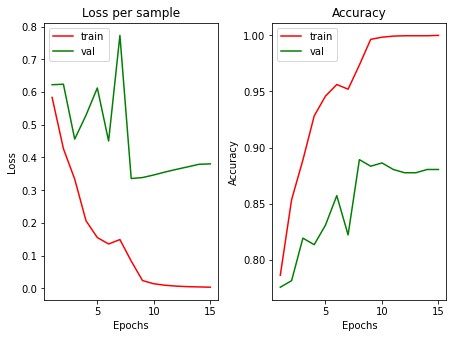

In [14]:
googlenet = torchvision.models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.grad_requires = False

num_ftrs = googlenet.fc.in_features

googlenet.fc = nn.Linear(num_ftrs, len(categories), bias=True)

googlenet = googlenet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(googlenet.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

googlenet,losses_train['googlenet'],accs_train['googlenet'],losses_val['googlenet'],accs_val['googlenet'] = train_model(googlenet, criterion, optimizer_ft, exp_lr_scheduler,loaders_norm, dataset_sizes_no_aug, num_epochs=15)
path_to_store = os.path.join(path_models,googlenet.__class__.__name__)
torch.save(googlenet.state_dict(), path_to_store)

plot_loss_acc(losses_train['googlenet'],losses_val['googlenet'],accs_train['googlenet'],accs_val['googlenet'], path_plots, 'googlenet_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_norm['test'], googlenet)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#### ResNet101 - No Augmentation and with Transfer Learning

Starting Training of the network ResNet
 --------------------------------
Epoch 0/14
----------


100%|██████████| 98/98 [01:15<00:00,  1.29it/s]


train 	 Loss: 1.0364 Acc: 0.6236


100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


val 	 Loss: 1.4051 Acc: 0.5598

Epoch 1/14
----------


100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


train 	 Loss: 0.7485 Acc: 0.7244


100%|██████████| 11/11 [00:04<00:00,  2.65it/s]


val 	 Loss: 1.5379 Acc: 0.5831

Epoch 2/14
----------


100%|██████████| 98/98 [01:27<00:00,  1.13it/s]


train 	 Loss: 0.7006 Acc: 0.7466


100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


val 	 Loss: 0.7608 Acc: 0.7055

Epoch 3/14
----------


100%|██████████| 98/98 [01:28<00:00,  1.10it/s]


train 	 Loss: 0.5215 Acc: 0.8197


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


val 	 Loss: 0.7685 Acc: 0.7493

Epoch 4/14
----------


100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


train 	 Loss: 0.4156 Acc: 0.8622


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


val 	 Loss: 0.6325 Acc: 0.7901

Epoch 5/14
----------


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


train 	 Loss: 0.3235 Acc: 0.8915


100%|██████████| 11/11 [00:04<00:00,  2.56it/s]


val 	 Loss: 0.8925 Acc: 0.7259

Epoch 6/14
----------


100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


train 	 Loss: 0.2869 Acc: 0.8970


100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


val 	 Loss: 0.8416 Acc: 0.7638

Epoch 7/14
----------


100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


train 	 Loss: 0.1840 Acc: 0.9401


100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


val 	 Loss: 0.4481 Acc: 0.8513

Epoch 8/14
----------


100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


train 	 Loss: 0.0810 Acc: 0.9826


100%|██████████| 11/11 [00:04<00:00,  2.62it/s]


val 	 Loss: 0.4321 Acc: 0.8630

Epoch 9/14
----------


100%|██████████| 98/98 [01:28<00:00,  1.10it/s]


train 	 Loss: 0.0397 Acc: 0.9948


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


val 	 Loss: 0.4506 Acc: 0.8601

Epoch 10/14
----------


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


train 	 Loss: 0.0187 Acc: 0.9971


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


val 	 Loss: 0.5243 Acc: 0.8630

Epoch 11/14
----------


100%|██████████| 98/98 [01:31<00:00,  1.08it/s]


train 	 Loss: 0.0095 Acc: 0.9984


100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


val 	 Loss: 0.5703 Acc: 0.8601

Epoch 12/14
----------


100%|██████████| 98/98 [01:31<00:00,  1.07it/s]


train 	 Loss: 0.0054 Acc: 0.9984


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


val 	 Loss: 0.6020 Acc: 0.8601

Epoch 13/14
----------


100%|██████████| 98/98 [01:30<00:00,  1.08it/s]


train 	 Loss: 0.0035 Acc: 0.9987


100%|██████████| 11/11 [00:04<00:00,  2.43it/s]


val 	 Loss: 0.6555 Acc: 0.8571

Epoch 14/14
----------


100%|██████████| 98/98 [01:30<00:00,  1.08it/s]


train 	 Loss: 0.0018 Acc: 0.9997


100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


val 	 Loss: 0.6384 Acc: 0.8601

Training complete in 23m 13s
Best val Acc: 0.862974
---------------


NameError: name 'loaders' is not defined

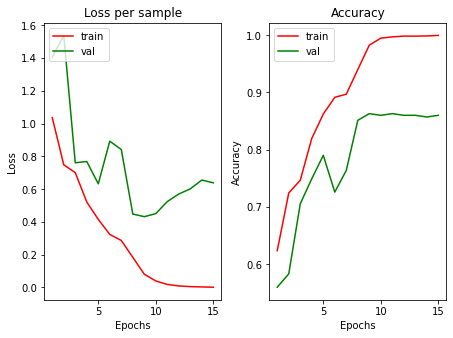

In [16]:
resnet101_no_aug = torchvision.models.resnet101(pretrained=True)

for param in resnet101_no_aug.parameters():
    param.grad_requires = False

num_ftrs = resnet101_no_aug.fc.in_features

resnet101_no_aug.fc = nn.Linear(num_ftrs, len(categories), bias=True)

resnet101_no_aug = resnet101_no_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(resnet101_no_aug.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

resnet101_no_aug,losses_train['resnet101_no_aug'],accs_train['resnet101_no_aug'],losses_val['resnet101_no_aug'],accs_val['resnet101_no_aug'] = train_model(resnet101_no_aug, criterion, optimizer_ft, exp_lr_scheduler,loaders_no_aug, dataset_sizes_no_aug, num_epochs=15)
path_to_store = os.path.join(path_models,resnet101_no_aug.__class__.__name__ + '_101_no_aug')
torch.save(resnet101_no_aug.state_dict(), path_to_store)

plot_loss_acc(losses_train['resnet101_no_aug'],losses_val['resnet101_no_aug'],accs_train['resnet101_no_aug'],accs_val['resnet101_no_aug'], path_plots, 'resnet101_no_aug_plot')

print('-' * 15)

test_accuracy = check_accuracy(loaders_no_aug['test'], resnet101_no_aug)
print("Model Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

#When running this network, the test set given was not defined, hence the error in the end, however the performance of this network in the test set can be seen in CNN_Flower